<h1> 캐글에 일단 제출 해보자 </h1>

In [ ]:
# 데이터 다운로드 
!wget –no-check-certificate 'https://docs.google.com/uc?export=download&id=1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0' -O kaggle-kakr-housing-data.zip

--2023-05-15 15:29:08--  http://xn--no-check-certificate-2t2l/
Resolving xn--no-check-certificate-2t2l (xn--no-check-certificate-2t2l)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--no-check-certificate-2t2l’
--2023-05-15 15:29:08--  https://docs.google.com/uc?export=download&id=1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0
Resolving docs.google.com (docs.google.com)... 142.251.163.138, 142.251.163.102, 142.251.163.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.163.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h6p34321qi6nnfomqto9v8i75os7o0lg/1684164525000/17597719433809694239/*/1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0?e=download&uuid=a5c3451b-0eba-43dc-982b-f3ad009fef19 [following]
--2023-05-15 15:29:09--  https://doc-00-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h6p34321qi6nnfomqto9v8i75o

In [ ]:
# 다운로드 받은 zip파일 압축풀기
!unzip -qq ./kaggle-kakr-housing-data.zip

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#--------------------------------------------------------------------------------------------------------------------------------------

train_data_path = join('./data/train.csv')
sub_data_path = join('./data/test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

#--------------------------------------------------------------------------------------------------------------------------------------
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

#--------------------------------------------------------------------------------------------------------------------------------------
y = data['price']
del data['price']

train_len = len(data)
data = pd.concat((data, sub), axis=0)

sub_id = data['id'][train_len:]
del data['id']

data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

#--------------------------------------------------------------------------------------------------------------------------------------
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

#--------------------------------------------------------------------------------------------------------------------------------------
y_log_transformation = np.log1p(y)

sub = data.iloc[train_len:, :] # 테스트 데이터
x = data.iloc[:train_len, :] # 학습데이터 

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


<div class="markdown-google-sans">

## <strong> 앙상블 학습 </strong>
</div>


## Averaging

In [ ]:
gboost = GradientBoostingRegressor(random_state=2023)
xgboost = xgb.XGBRegressor(random_state=2023)
lightgbm = lgb.LGBMRegressor(random_state=2023)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

**Cross Validation** 

In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [ ]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8609
Model: XGBoost, CV score:0.8861
Model: LightGBM, CV score:0.8819


In [ ]:
def AveragingBlending(models, x, y, sub_x):
    # 모델학습
    for m in models : 
        m['model'].fit(x.values, y)
    
    # 모델예측
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])

    # 각 모델 에측의 평균을 return
    return np.mean(predictions, axis=1)

In [ ]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [ ]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


<div class="markdown-google-sans">

## 미션 1) 모델 예측결과를 csv로 만들기
</div>


이제 완전히 준비가 끝났습니다. 이때 활용할 수 있는 함수는 [`to_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html)함수 입니다. 
샘플 형태인 `sample_submission.csv`를 로드했을 때와 동일한 형식으로 저장해야만 정확하게 제출될 것 입니다.

In [ ]:
# 저장핦 파일명은 submission.csv로 하였습니다.
my_submission_path = './data/submission.csv'

###################
###  미션 1 코드 ####
###################
# result를 'my_submission_path'란 이름의 csv로 저장해 주세요. 

result.to_csv(my_submission_path, index=False)

## 캐글 사이트에 제출하기

- [캐글 코리아와 함께하는 2nd ML대회](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

### 미션 2-1) 여러분이 제출한 Public Score는 몇점이신가요? 
소수점을 제외한 첫번째 제출 점수를 이곳에 작성해 주세요. 


119927점

### 미션 2-2) 슬랙(Slack)에 여러분의 첫번째 제출결과를 스크린 캡쳐하여 공유해주세요.

**공유하셨다면 "예"를 아니면 "아직 아니요"라고 밑에 작성해주세요.**


예

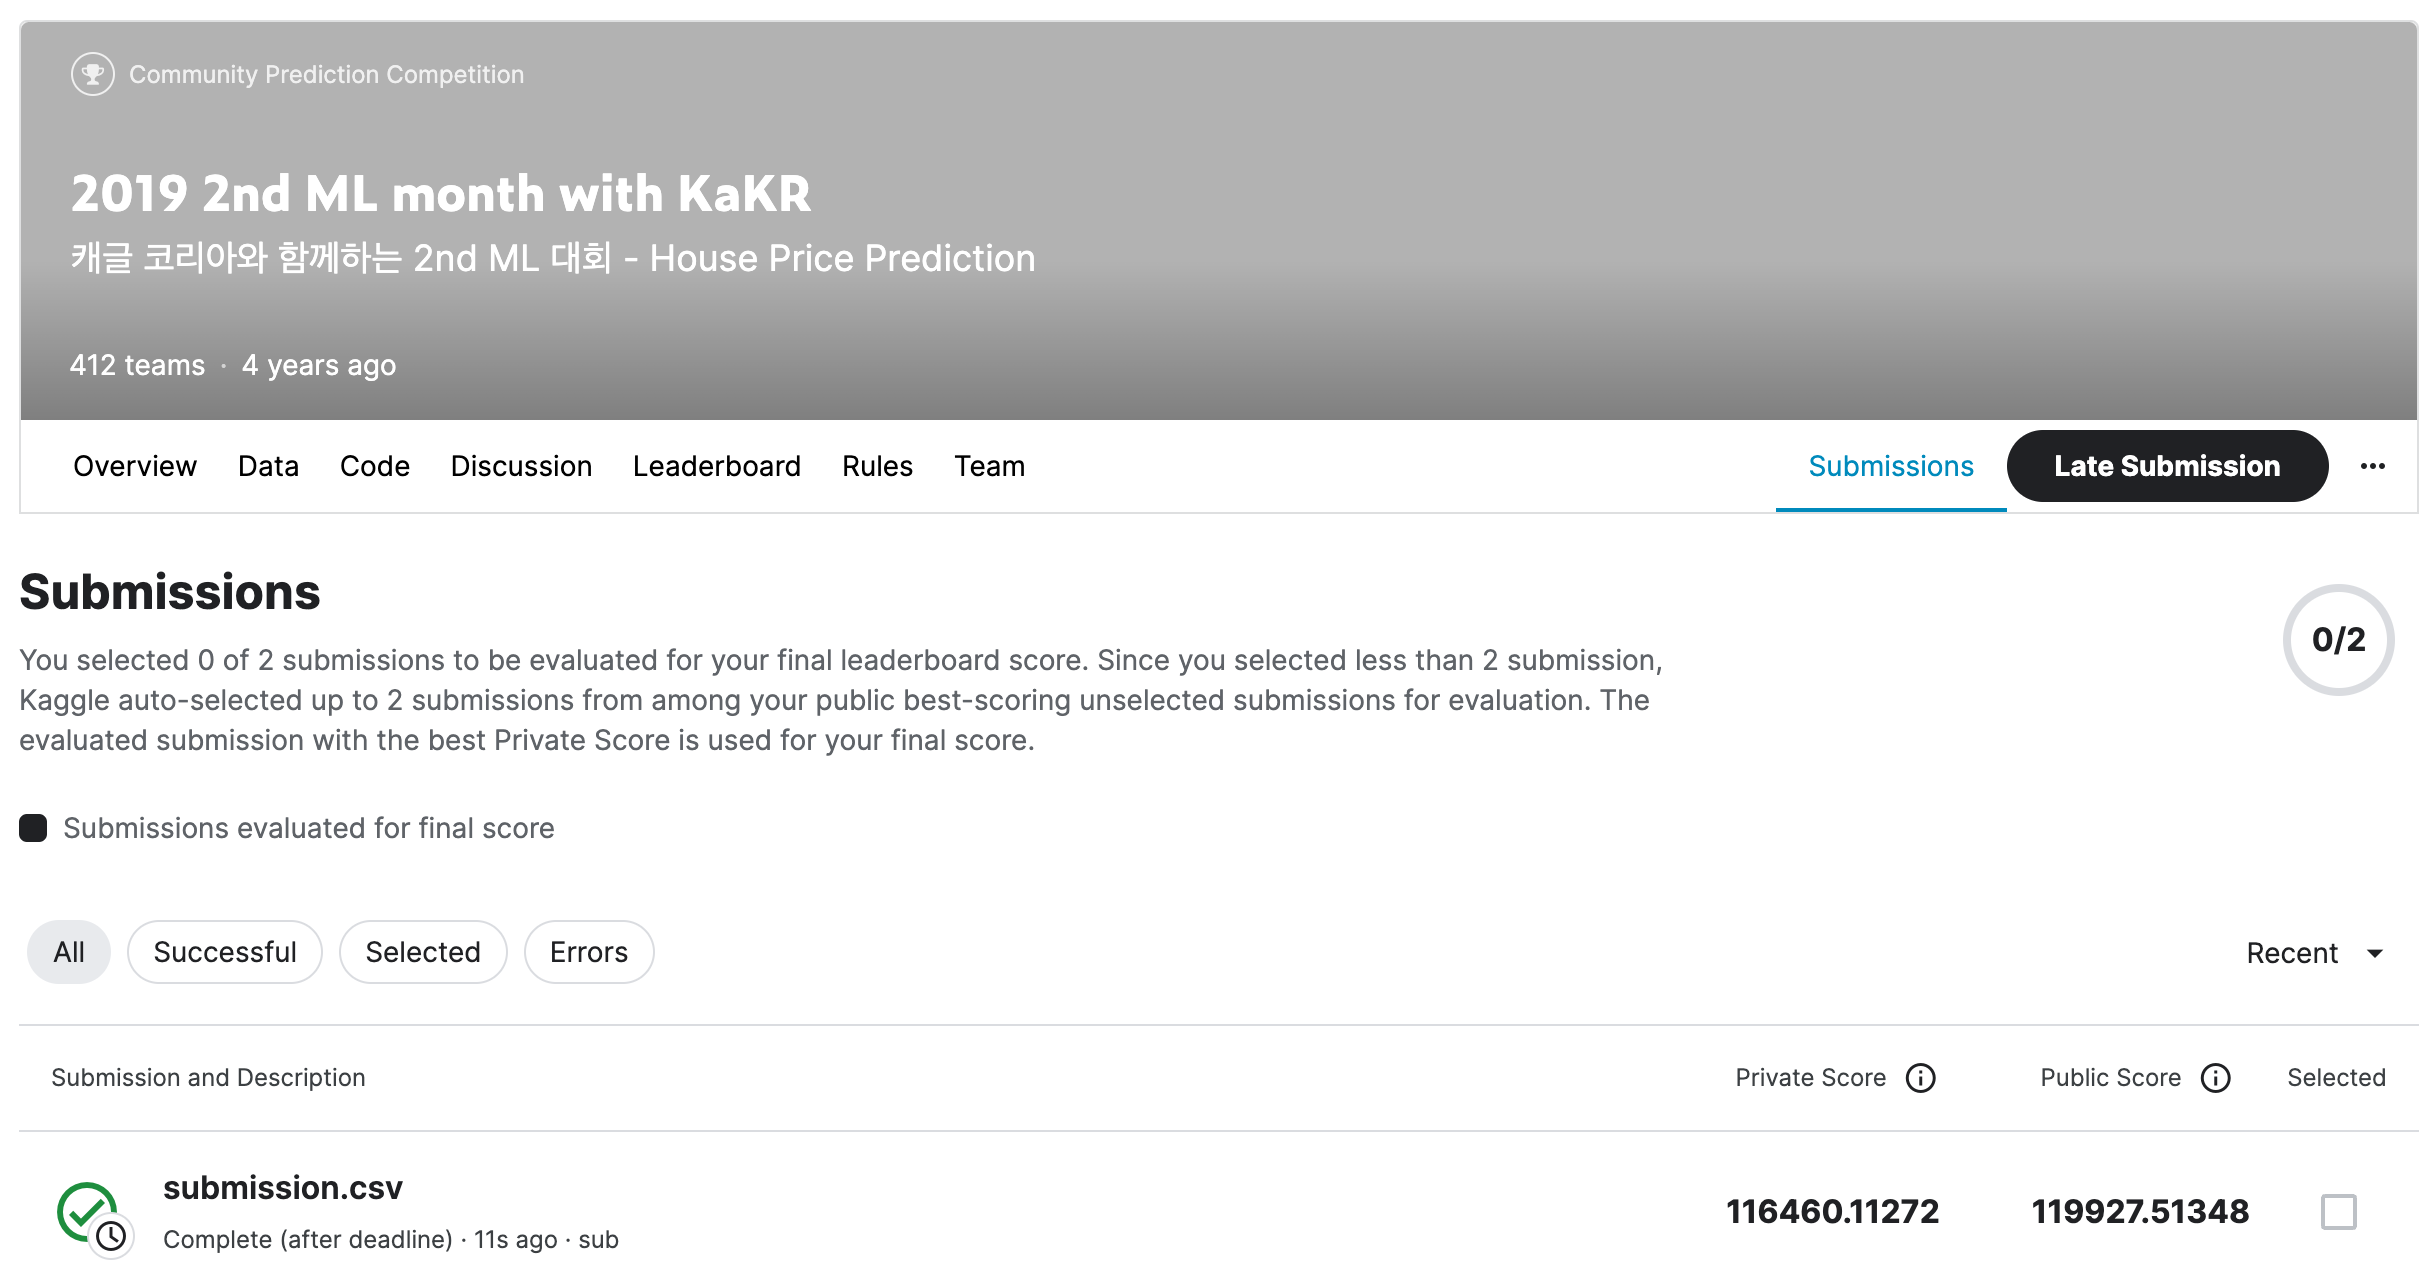

## 더 좋은 성능의 모델 만들기

In [ ]:
train = x # 기존 학습 데이터를 train으로 
test = sub # 기존 테스트 데이터를 test로 
y = np.log1p(y) # y값(price)의 로그변환

### RMSE 계산함수 만들기

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2023        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

<div class="markdown-google-sans">

## 스코어를 출력하는 함수 만들기
</div>


In [ ]:
def get_scores(models, train, y):
    df = {} # 결과 저장을 위한 table 생성
    for model in models: # 모델명 추출
        model_name = model.__class__.__name__
        # 0.2만 validation에 사용
        X_train, X_val, y_train, y_val = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델학습
        model.fit(X_train, y_train)

        #학습된 모델 테스트
        y_pred = model.predict(X_val) 
        
        # rmse를 이용한 계산
        df[model_name] = rmse(y_val, y_pred)
        
        # 테이블을 DataFrame으로 변환
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [ ]:
model = LGBMRegressor(random_state=random_state)

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(x, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2023), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

### 생강먹고 생각 좀 해 1 : 위에 출력된 메세지에 나타난 'totalling 20 fits' 에서 20은 어떻게 계산된 값일까요?



param_grid = {'n_estimators': [50, 100], 'max_depth': [1, 10]}에서  
'n_estimators'는 트리의 개수, 'max_depth'는 트리의 최대 깊이를 의미하는데,  
가능한 모든 **순서쌍 (n_estimators, max_depth)**는  
(50, 1), (50, 10), (100, 1), (100, 10), 이렇게 총 **4가지**가 가능합니다.  
  
  
이때, GridSearchCV의 파라미터로 cv 값을 5로 지정했으므로 교차검증을 위한 fold 개수가 5개이고,  
각 fold마다 **순서쌍 (n_estimators, max_depth)**로 가능한 4가지를 반복하므로  
**5 X 4 = 20 fits**가 나옵니다.  
따라서 "Fitting 5 folds for each of 4 candidates, totalling 20 fits"라는 말이 나오게 됩니다.

In [ ]:
grid_model.cv_results_

{'mean_fit_time': array([0.31561713, 0.42793226, 0.80086727, 1.19769082]),
 'std_fit_time': array([0.02874465, 0.04034719, 0.11130414, 0.11859526]),
 'mean_score_time': array([0.0220345 , 0.04297066, 0.06421423, 0.05808268]),
 'std_score_time': array([0.00736048, 0.00585512, 0.00879098, 0.02826973]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885212, -0.02664695]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041411, -0.02795762]),
 'split2_test_score': array([-0.07354904

In [ ]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339763, -0.05502319, -0.02917323, -0.02702383])

**데이터 프레임 합쳐서 표현해 보기**

In [ ]:
results = pd.DataFrame(params)
results['score'] = score

results


,max_depth,n_estimators,score
0,1,50,-0.073398
1,1,100,-0.055023
2,10,50,-0.029173
3,10,100,-0.027024


### 생각먹고 생각 좀 해 2 : GridSearchCV 에서 모델을 초기화할 때 scoring 인자에는 무엇을 넣었나요?


```
# 정답작성 : neg_mean_squared_error
```


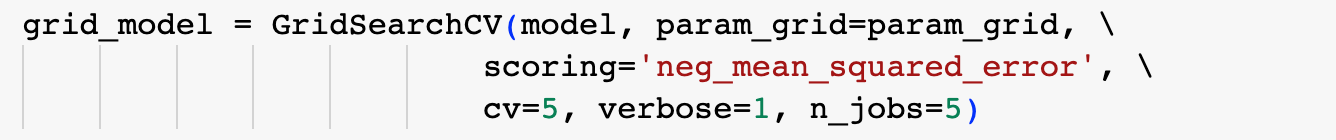

### 생강먹고 생각 좀 해 3 : 위 링크의 scoring parameter 표를 보면 이 파라미터를 3개의 범주로 묶어서 표기해주고 있습니다. 이 3개의 범주가 무엇인가요? 각자의 답을 슬랙에서 공유해주세요.


```
(1) Classification (2) Clustering (3) Regression
```


In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073398,0.270920
1,1,100,-0.055023,0.234570
2,10,50,-0.029173,0.170802
3,10,100,-0.027024,0.164389


## 미션 3-1) : 컬럼명 바꾸기
`results` 컬럼의 이름을 RMSLE로 변환해 주도록 하겠습니다. 판다스에서 컬럼의 이름 변환은 [rename](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html)으로 할 수 있습니다. 아래에 코드를 작성하고 출력해보세요.

### results 데이터프레임의 'RMSE'라는 컬럼 이름을 'RMSLE'로 변환

In [ ]:
###################
###  미션 3-1 코드 ###
###################
## 미션 3-1) 컬럼명 바꾸기
results = results.rename(columns={'RMSE':'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073398,0.270920
1,1,100,-0.055023,0.234570
2,10,50,-0.029173,0.170802
3,10,100,-0.027024,0.164389


이제 마지막 할 일은 RMSLE가 낮은 순서대로 정렬하는 것뿐이군요! 


## 미션 3-2) : RMSLE를 낮은 순서대로 정렬하기
sort_values로 간단히 할 수 있습니다. 공식 문서를 참고해 직접 작성해 보세요.

In [ ]:
###################
###  미션 3-2 코드 ###
###################
## 미션 3-2 : results 데이터 프레임에서 RMSLE가 낮은 순으로 정렬하기 
results = results.sort_values(by='RMSLE', ascending=True)
results 

# 다른 방법
# results = results.sort_values(['RMSLE'])
# results = results.sort_values('RMSLE', ascending=True)

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164389
2,10,50,-0.029173,0.170802
1,1,100,-0.055023,0.234570
0,1,50,-0.073398,0.270920


## 미션 4) : 함수로 만들기 
지금까지의 `GridSearchCV`를 통해 진행한 내용들을 간단히 함수로 만들어 보도록 하겠습니다. 

다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.

In [ ]:
###################
###  미션 4-3 코드 ###
###################
## 미션 4-3 : 함수로 만들기

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산
    results['RMSLE'] = np.sqrt(-1 * results['score'])

    # RMSLE 값으로 장렬
    results = results.sort_values('RMSLE', ascending=True)
    # results = results.sort_values(by='RMSLE')
    # results = results.sort_values(['RMSLE'])

    return results

## 하이퍼 파라미터 튜닝결과 제출해보기

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164389
2,10,50,-0.029173,0.170802
1,1,100,-0.055023,0.234570
0,1,50,-0.073398,0.270920


In [ ]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [ ]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [ ]:
submission_path = './data/sample_submission.csv'
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [ ]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format('./data', 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

./data/submission_lgbm_RMSLE_0.164399.csv


In [ ]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = './data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

./data/submission_lgbm_RMSLE_0.164399.csv saved!
